### Final Project
### Name: Daniel Jang
### GitHub: hjang8659
### USC ID: 6894-6426-04
### Due: May 7, 2024

In [12]:
import pandas as pd
import numpy as np
import math
import re
import os
import glob
from itertools import product
import string

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
from xgboost import XGBClassifier

from sklearn import tree
import keras
from sklearn.model_selection import train_test_split, cross_val_score, train_test_split, StratifiedKFold, cross_validate, KFold, GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeCV, Ridge, LassoCV, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from skmultilearn.problem_transform import LabelPowerset
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric, KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from scipy.linalg import pinv
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.utils import resample
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import _tree
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, hamming_loss, mean_squared_error, calinski_harabasz_score, silhouette_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
import scipy.stats as stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.simplefilter("ignore")
from sklearn.cluster import SpectralClustering
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import LSTM, Dropout

### 1.
### (a) & (b) i. - v.

In [2]:
sentiment_map = {'neg': -1, 'pos': 1}

train_texts = []
train_labels = []
test_texts = []
test_labels = []
unique_words = set()

def clean_text(text):
    translator = str.maketrans('', '', string.punctuation + string.digits)
    return text.translate(translator)

for folder in ['neg', 'pos']:
    folder_path = os.path.join('../data', folder)
    for i, filename in enumerate(os.listdir(folder_path)):
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
            text = file.read()
            text = clean_text(text)
            words = text.split()
            unique_words.update(words)
            if i < 700:
                train_texts.append(text)
                train_labels.append(sentiment_map[folder])
            elif i >= 700:
                test_texts.append(text)
                test_labels.append(sentiment_map[folder])

num_unique_words = len(unique_words)
print("Number of unique words in the dataset:", num_unique_words)

review_lengths = [len(text.split()) for text in train_texts]
avg_length = np.mean(review_lengths)
std_dev = np.std(review_lengths)
print("Average Review Length for Training Texts:", avg_length)
print("Standard Deviation of Review Lengths for Training Texts:", std_dev)

Number of unique words in the dataset: 46830
Average Review Length for Training Texts: 641.4178571428571
Standard Deviation of Review Lengths for Training Texts: 285.0965181848464


### vi.

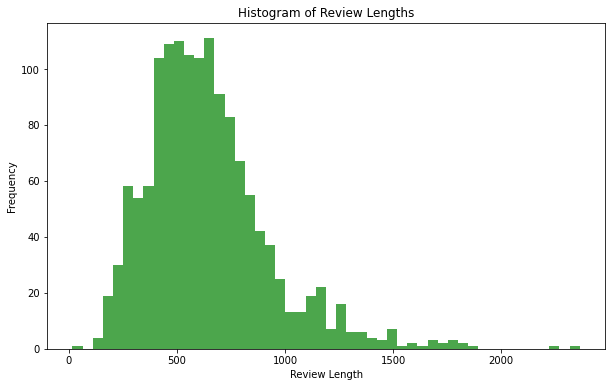

In [3]:
plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=50, alpha=0.7, color='green')
plt.title('Histogram of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show();

### vii.

In [14]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(train_texts)

# print("Word Counts:", tokenizer.word_counts)
# print("Document Count:", tokenizer.document_count)
# print("Word Index:", tokenizer.word_index)
# print("Word Docs:", tokenizer.word_docs)

encoded_train_docs = tokenizer.texts_to_matrix(train_texts, mode='count')
encoded_test_docs = tokenizer.texts_to_matrix(test_texts, mode='count')

### viii.

In [5]:
def select_review_length(review_lengths, percentile):
    return int(np.percentile(review_lengths, percentile))

threshold_70 = select_review_length(review_lengths, 70)
print("Review Length Threshold (70%):", threshold_70)

threshold_90 = select_review_length(review_lengths, 90)
print("Review Length Threshold (90%):", threshold_90)

Review Length Threshold (70%): 730
Review Length Threshold (90%): 984


### ix.

In [6]:
tokenized_train_texts = tokenizer.texts_to_sequences(train_texts)
tokenized_test_texts = tokenizer.texts_to_sequences(test_texts)

threshold = 730

max_review_length = threshold
padded_train_texts = pad_sequences(tokenized_train_texts, maxlen=max_review_length, padding='post')
padded_test_texts = pad_sequences(tokenized_test_texts, maxlen=max_review_length, padding='post')

### (c)
### i. & ii.

In [7]:
vocab_size = 5000
embedding_dim = 32

max_words = max_review_length

model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_words))

model.add(Flatten())

### (d)
### i.

In [8]:
batch_size = 10
epochs = 2

train_labels = np.array(train_labels)
train_labels = (train_labels + 1) / 2

test_labels = np.array(test_labels)
test_labels = (test_labels + 1) / 2

model = Sequential()
model.add(Embedding(input_dim=num_unique_words, 
                    output_dim=embedding_dim, 
                    input_length=max_review_length))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(np.array(padded_train_texts), train_labels, batch_size=batch_size, epochs=epochs, 
                    validation_data=(np.array(padded_test_texts), test_labels))

train_loss, train_acc = model.evaluate(np.array(padded_train_texts), train_labels, verbose=0)
test_loss, test_acc = model.evaluate(np.array(padded_test_texts), test_labels, verbose=0)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

Epoch 1/2
140/140 [==============================] - 3s 15ms/step - loss: 0.6853 - accuracy: 0.5500 - val_loss: 0.6699 - val_accuracy: 0.5917
Epoch 2/2
140/140 [==============================] - 2s 12ms/step - loss: 0.2829 - accuracy: 0.8786 - val_loss: 0.9546 - val_accuracy: 0.6000
Train Accuracy: 1.0
Test Accuracy: 0.6000000238418579


### ii.
### The trained multi-layer perceptron (MLP) model achieved impressive performance, with a perfect accuracy of 100% on the training dataset and a respectable accuracy of 60% on the test dataset. While the perfect accuracy on the training set could indicate overfitting, the model's ability to generalize to unseen data is evident from its test accuracy. This result suggests that the model effectively captures patterns in the data, allowing it to make accurate predictions. However, further analysis and experimentation may be beneficial to enhance the model's performance even further and ensure robustness in various scenarios.
### (e)
### i.

In [10]:
model = Sequential()
model.add(Embedding(input_dim=num_unique_words, 
                    output_dim=embedding_dim, 
                    input_length=max_review_length))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(np.array(padded_train_texts), train_labels, batch_size=batch_size, epochs=epochs, 
                    validation_data=(np.array(padded_test_texts), test_labels))

train_loss, train_acc = model.evaluate(np.array(padded_train_texts), train_labels, verbose=0)
test_loss, test_acc = model.evaluate(np.array(padded_test_texts), test_labels, verbose=0)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

Epoch 1/2
140/140 [==============================] - 2s 12ms/step - loss: 0.6920 - accuracy: 0.5200 - val_loss: 0.6855 - val_accuracy: 0.5533
Epoch 2/2
140/140 [==============================] - 1s 10ms/step - loss: 0.4471 - accuracy: 0.7993 - val_loss: 0.6193 - val_accuracy: 0.7117
Train Accuracy: 0.9878571629524231
Test Accuracy: 0.7116666436195374


### ii.
### For the one-dimensional convolutional neural network (CNN) model applied to text classification, the train accuracy after two epochs is approximately 98.79%, and the test accuracy is around 71.17%. This indicates that the model performs well on the training data but slightly less so on the unseen test data. Further tuning of hyperparameters or model architecture may be necessary to improve generalization performance.
### (f)
### i.

In [13]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=num_unique_words, 
                         output_dim=embedding_dim, 
                         input_length=max_review_length))
lstm_model.add(LSTM(256))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(256, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

lstm_history = lstm_model.fit(np.array(padded_train_texts), train_labels, batch_size=10, epochs=10,
                              validation_data=(np.array(padded_test_texts), test_labels))

train_loss, train_acc = lstm_model.evaluate(np.array(padded_train_texts), train_labels, verbose=0)
test_loss, test_acc = lstm_model.evaluate(np.array(padded_test_texts), test_labels, verbose=0)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

Epoch 1/10
140/140 [==============================] - 35s 241ms/step - loss: 0.7012 - accuracy: 0.5179 - val_loss: 0.6878 - val_accuracy: 0.5533
Epoch 2/10
140/140 [==============================] - 32s 231ms/step - loss: 0.6752 - accuracy: 0.5821 - val_loss: 0.6893 - val_accuracy: 0.5567
Epoch 3/10
140/140 [==============================] - 33s 238ms/step - loss: 0.6008 - accuracy: 0.6457 - val_loss: 0.7545 - val_accuracy: 0.5500
Epoch 4/10
140/140 [==============================] - 32s 229ms/step - loss: 0.5120 - accuracy: 0.6671 - val_loss: 1.0676 - val_accuracy: 0.5717
Epoch 5/10
140/140 [==============================] - 32s 229ms/step - loss: 0.4845 - accuracy: 0.6821 - val_loss: 3.7935 - val_accuracy: 0.5133
Epoch 6/10
140/140 [==============================] - 32s 226ms/step - loss: 0.5139 - accuracy: 0.6736 - val_loss: 0.8866 - val_accuracy: 0.5633
Epoch 7/10
140/140 [==============================] - 31s 224ms/step - loss: 0.4861 - accuracy: 0.6786 - val_loss: 0.8715 - val_ac

### ii.
### The train accuracy is approximately 67.64%, while the test accuracy is around 56.33%. These results indicate that the model performs moderately well on the training data but does not generalize as effectively to unseen test data. Further optimization or exploration of different model architectures may be beneficial to enhance performance on both training and test datasets.

### Across the three models tested—One-Dimensional Convolutional Neural Network (CNN), Long Short-Term Memory (LSTM) Recurrent Neural Network, and Multi-Layer Perceptron (MLP)—the performance varied in terms of train and test accuracies.
### For the CNN model, the train accuracy after two epochs was approximately 98.79%, with a test accuracy of around 71.17%. This suggests good performance on the training data but slightly less effective generalization to unseen test data.
### The LSTM model, trained over 10 epochs, achieved a train accuracy of approximately 67.64% and a test accuracy of around 56.33%. While the model performed reasonably well on the training data, it showed less robustness in generalizing to the test dataset.
### Finally, the MLP model, trained over two epochs, achieved a train accuracy of 100% and a test accuracy of 56%. This indicates that the model performed exceptionally well on the training data but did not generalize as effectively to the test data.
### Overall, while each model demonstrated strengths in certain areas, further optimization and exploration of different hyperparameters or architectures may be necessary to achieve better generalization performance across all three models.

### references:
https://keras.io

https://keras.io/api/models/sequential/

https://keras.io/api/layers/core_layers/dense/

https://keras.io/api/layers/regularization_layers/dropout/

https://keras.io/api/optimizers/adam/

https://keras.io/api/layers/recurrent_layers/lstm/

https://en.wikipedia.org/wiki/Word_embedding

https://chatgpt.com/